# ***PROYECTO ESPECIALIZACIÓN EN CIENCIA DE DATOS E IA***

**Presentado por:** 
- Jonatan Andres Londoño Taborda
- John Freddy Ossa Patiño
- Felipe Londoño Mendoza

--------------------------------------------

# 📘 Contexto del Proyecto

El presente trabajo tiene como objetivo construir un modelo supervisado de clasificación que permita automatizar la decisión sobre el tratamiento de órdenes de desviaciones significativas en consumos de los servicios de energía, acueducto, alcantarillado y gas que presta Empresas Públicas de Medellín (EPM) a sus clientes, generadas cuando se detectan consumos que se salen de unos rangos establecidos por ley en un periodo determinado.

Actualmente, estas órdenes son revisadas manualmente por un equipo de analistas que determina si deben legalizar o enviarse una revisión a terreno para tener mas argumentos. El desarrollo de este modelo busca replicar ese proceso humano a partir de datos históricos, con el fin de reducir visitas innecesarias y optimizar los costos operativos asociados.

---

## 🧪 Proceso de Análisis

Para lograr este objetivo, se ejecutará el siguiente flujo de trabajo:

1. **Análisis Exploratorio de Datos (EDA)**
2. **Depuración y preparación de los datos**
3. **Entrenamiento y comparación de modelos de clasificación**:
   - Regresión Logística
   - Random Forest
   - XGBoost Lineal
4. **Conclusiones**

---

## 📊 Evaluación y Métricas

- Se evaluará el desempeño de cada modelo utilizando la métrica F1 Score, ideal para escenarios con datos desbalanceados, ya que equilibra la precisión.
- La división de los datos será del 80% para entrenamiento y 20% para prueba.

Además, el modelo generará una probabilidad de legalización para cada orden. Si esta probabilidad supera el 80%, se considerará que la orden puede ser legalizada automáticamente, sin la intervención de un analista.

---


## 📂 Descripción de los Datos

Para el entrenamiento del modelo supervisado de clasificación se cuenta con un conjunto de datos históricos que contiene información sobre órdenes de desviación significativa generadas por incrementos en el consumo de servicios públicos. Estas órdenes fueron previamente revisadas por analistas, quienes tomaron decisiones basadas en las condiciones observadas.

### 🎯 Variable Objetivo: `RESPUESTA`

La variable `RESPUESTA` representa la decisión final tomada por el analista, y se comporta de la siguiente manera:

| Caso | ¿Modifica Consumo? | ¿Envía a terreno? | RESPUESTA |
|------|--------------------|-------------------|-----------|
| 1    | Sí                 | No                | 1         |
| 2    | Sí                 | Sí                | 1         |
| 3    | No                 | Sí                | 1         |
| 4    | No                 | No                | 0         |

#### 🧠 Interpretación de los casos:
- **Caso 1:** El analista detecta un error claro en el consumo y lo ajusta sin necesidad de verificación en terreno.
- **Caso 2:** El analista ajusta parcialmente el consumo, pero requiere una visita en terreno para validar la parte restante antes de decidir su facturación definitiva.
- **Caso 3:** El analista no ajusta el consumo por falta de evidencia suficiente, pero mantiene dudas que requieren una inspección en terreno.
- **Caso 4:** El consumo investigado es considerado válido y no necesita ajustes ni verificación en terreno.

Por tanto, la clase `1` agrupa todas las situaciones en las que se toma alguna acción correctiva o preventiva adicional, mientras que la clase `0` representa los casos cerrados sin intervención alguna.

---

### 🧾 Variables Predictoras

Las demás columnas del dataset representan condiciones observadas por el analista en el momento de tomar la decisión, y serán utilizadas como **variables predictoras** en el modelo. Estas incluyen, entre otras:

- `CONSUMO_CRITICADO`: Valor del consumo que se encuentra en investigación.
- `SERVICIO`: Tipo de servicio involucrado (agua, energía, etc.).
- `CATEGORIA`: Segmento del usuario (residencial, industrial, etc.).
- `NIVEL_TENSION`: Capacidad de energía entrega y solo aplica para el servicio de energía
- `ESTRATO`: Estrato socio economico del predio que de 1 a 6 y solo aplica para el sector residencial (CATEGORIA: Residencial)
- `LOCALIDAD`: Municipio donde se se presta el servicio.
- `FUNCION_ANALISIS`: Algoritmo o lógica aplicada para el análisis del consumo.
- `CALIFICACION`: Clasificación del nivel de desviación identificado.
- `OBS_LECTURA`: Observaciones sobre la lectura del medidor que realiza el lector.
- `PERIODICIDAD`: Frecuencia con la que se factura el servicio.

**Cantidad de observaciones**: 85.812

Estas variables permitirán al modelo aprender de los patrones y comportamientos históricos, con el objetivo de replicar las decisiones de los analistas en nuevos casos.

---


# *1.Carga de datos y análisis exploratorio de los datos (EDA)*

In [1]:
#Importación de la librerías que se usarán
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
mapeo_columnas = {
    'RESPUESTA': 'respuesta', 
    'CONSUMO_CRITICADO': 'consumo_criticado', 
    'SERVICIO': 'servicio',
    'CATEGORIA': 'categoria', 
    'NIVEL_TENSION': 'nivel_tension', 
    'ESTRATO': 'estrato', 
    'LOCALIDAD': 'localidad', 
    'FUNCION_ANALISIS': 'funcion_analisis',
    'CALIFICACION': 'calificacion',
    'OBS_LECTURA': 'obs_lectura',
    'PERIODICIDAD': 'periodicidads'
}

In [3]:
# Cargar el set de datos
archivo = "BD_ordenes.xlsx"
df = pd.read_excel(archivo)

df = df.rename(columns=mapeo_columnas)

df.head()

,respuesta,consumo_criticado,servicio,categoria,nivel_tension,estrato,localidad,funcion_analisis,calificacion,obs_lectura,periodicidads
0,1,0.0,701-ENERGÍA MDO REGULADO,3-INDUSTRIAL,220.0,NaN,5088-BELLO,CALCCOPR - Calcular Consumo Penalizado de Ener...,5035-BAJO ENERGIA (<-50%),30-VARIACION NIVEL DE UTILIZACIÓN,1
1,1,420.0,701-ENERGÍA MDO REGULADO,3-INDUSTRIAL,220.0,NaN,5088-BELLO,CALCCOPR - Calcular Consumo Penalizado de Ener...,5080-MUY ALTO (>500%),30-VARIACION NIVEL DE UTILIZACIÓN,1
2,1,99999.0,101-AGUA POTABLE,1-RESIDENCIAL,NaN,1.0,5088-BELLO,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),34-LECTURA MENOR,1
3,1,881.0,701-ENERGÍA MDO REGULADO,3-INDUSTRIAL,220.0,NaN,5088-BELLO,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),35-NO HAY JUSTIFICACION,1
4,1,99999.0,701-ENERGÍA MDO REGULADO,1-RESIDENCIAL,220.0,4.0,5001-MEDELLÍN,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),34-LECTURA MENOR,1


In [4]:
#Cantidad de órdenes por respuesta del analista
(df['respuesta'].value_counts(normalize=True) * 100).round(2).astype(str) + ' %'

respuesta
1    65.98 %
0    34.02 %
Name: proportion, dtype: object

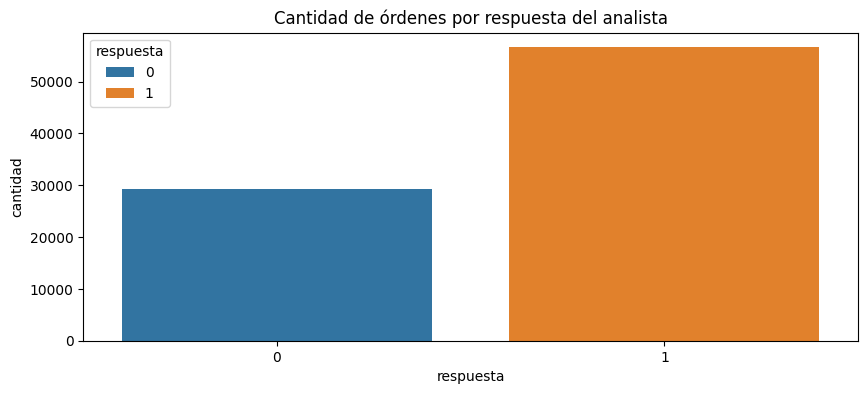

In [5]:
plt.figure(figsize=(10, 4))
sns.countplot(x='respuesta', hue='respuesta', data=df)
plt.ylabel('cantidad')
plt.title('Cantidad de órdenes por respuesta del analista');


El gráfico muestra la cantidad de órdenes clasificadas por los analistas según la variable respuesta, la cual indica si se tomó alguna acción (1) o no (0).

Existe un desbalance moderado en las respuestas:

respueta 1: 65.98%

respueta 2: 34.02%

Aunque respuesta = 1 es claramente dominante, la clase 0 todavía representa una proporción considerable del total.

In [6]:
# Agrupar por SERVICIO y obtener conteo de RESPUESTA
tabla_resumen = df.groupby('servicio')['respuesta'].value_counts().unstack(fill_value=0)

# Agregar columna con total por servicio
tabla_resumen['TOTAL'] = tabla_resumen.sum(axis=1)

# Ordenar de forma descendente
tabla_resumen_ordenada = tabla_resumen.sort_values(by='TOTAL', ascending=False)

# Mostrar resultado
tabla_resumen_ordenada


respuesta,0,1,TOTAL
servicio,,,
101-AGUA POTABLE,12916,24899,37815
701-ENERGÍA MDO REGULADO,7013,17540,24553
501-GAS NATURAL REGULADO,2403,4591,6994
249-AGUA POTABLE DE RIONEGRO ANT,4025,1908,5933
8003-AGUA POTABLE URABA,1285,2936,4221
240-AGUA POTABLE MALAMBO,397,2320,2717
7505-GAS NATURAL COMPRIMIDO (GNC),462,1392,1854
8000-AGUA POTABLE OCC.,659,963,1622
103-ALCANTARILLADO,4,58,62


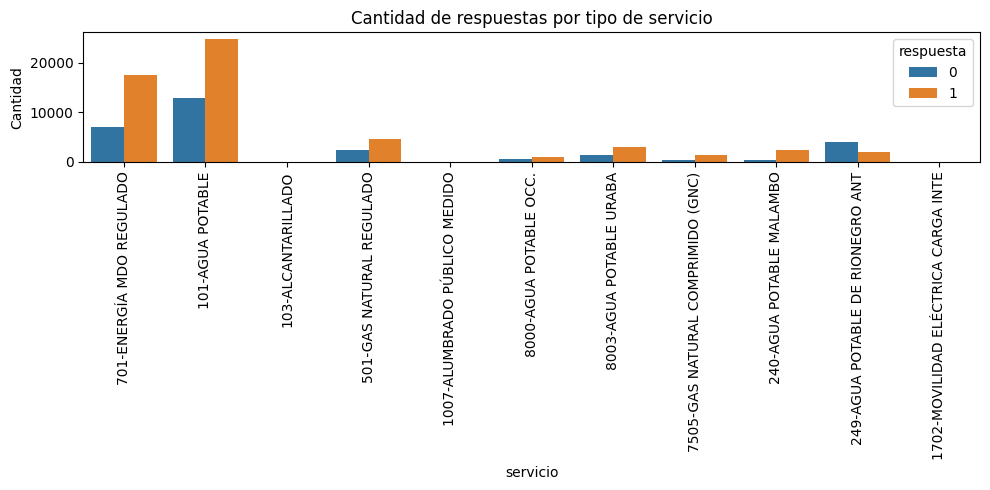

In [7]:
plt.figure(figsize=(10, 5))
sns.countplot(x='servicio', hue='respuesta', data=df)
plt.title("Cantidad de respuestas por tipo de servicio")
plt.xlabel("servicio")
plt.ylabel("Cantidad")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [8]:
# Agrupar por SERVICIO y obtener conteo de RESPUESTA
tabla_resumen = df.groupby('localidad')['respuesta'].value_counts().unstack(fill_value=0)

# Agregar columna con total por servicio
tabla_resumen['TOTAL'] = tabla_resumen.sum(axis=1)

# Ordenar de forma descendente
tabla_resumen_ordenada = tabla_resumen.sort_values(by='TOTAL', ascending=False)

# Mostrar resultado
tabla_resumen_ordenada

respuesta,0,1,TOTAL
localidad,,,
5001-MEDELLÍN,9175,19580,28755
5266-ENVIGADO,5425,10060,15485
5615-RIONEGRO,4611,3292,7903
5045-APARTADÓ,1569,5584,7153
5088-BELLO,2212,4157,6369
...,...,...,...
5125-CAICEDO,0,1,1
5660-SAN LUIS,0,1,1
5674-SAN VICENTE FERRER,0,1,1


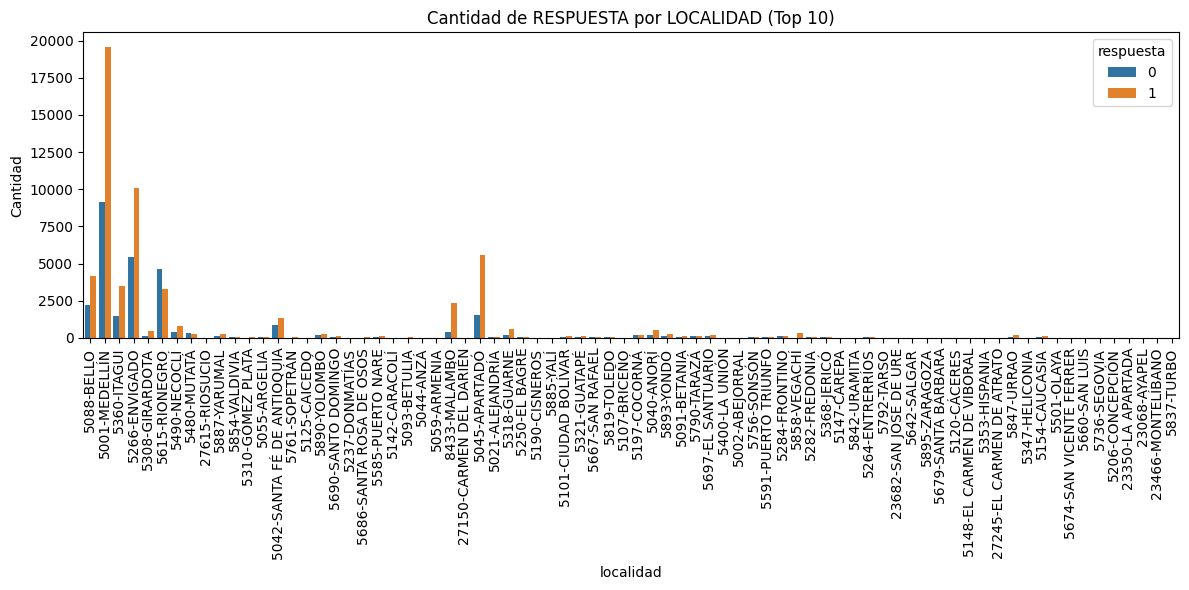

In [9]:
plt.figure(figsize=(12, 6))
#top_localidades = df['LOCALIDAD'].value_counts().nlargest(10).index
top_localidades = df['localidad'].value_counts().index
df_localidad_top = df[df['localidad'].isin(top_localidades)]
sns.countplot(x='localidad', hue='respuesta', data=df_localidad_top)
plt.title("Cantidad de RESPUESTA por LOCALIDAD (Top 10)")
plt.xlabel("localidad")
plt.ylabel("Cantidad")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [10]:
# Agrupar por SERVICIO y obtener conteo de RESPUESTA
tabla_resumen = df.groupby('categoria')['respuesta'].value_counts().unstack(fill_value=0)

# Agregar columna con total por servicio
tabla_resumen['total'] = tabla_resumen.sum(axis=1)

# Ordenar de forma descendente
tabla_resumen_ordenada = tabla_resumen.sort_values(by='total', ascending=False)

# Mostrar resultado
tabla_resumen_ordenada

respuesta,0,1,total
categoria,,,
1-RESIDENCIAL,25063,45940,71003
2-COMERCIAL,2403,6483,8886
3-INDUSTRIAL,1035,3443,4478
4-OFICIAL,455,578,1033
11-CONSUMOS EPMTELCO,138,43,181
5-ESPECIAL,36,73,109
7-AUTOCONSUMOS EPM,47,31,78
5-EXENTA,15,24,39
14-ENERGIA BOMBEO ACUEDUCTO,1,3,4


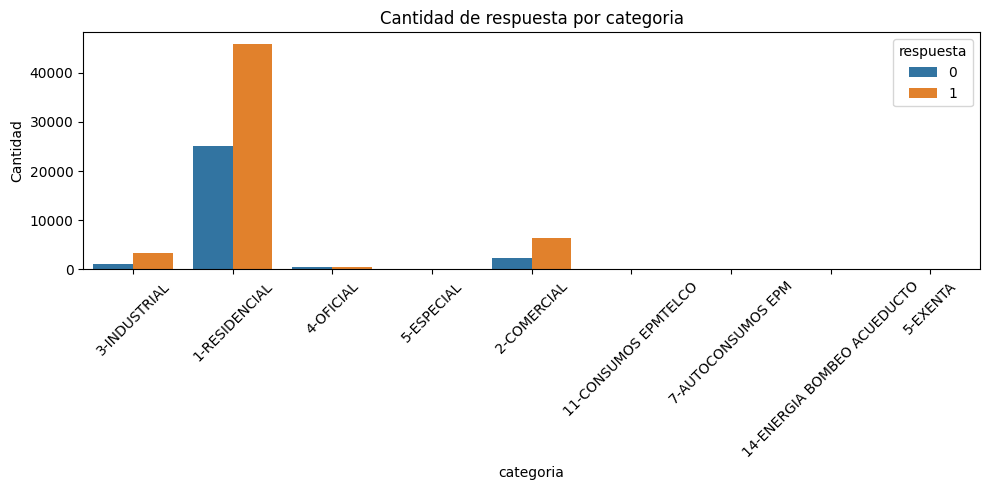

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(x='categoria', hue='respuesta', data=df)
plt.title("Cantidad de respuesta por categoria")
plt.xlabel("categoria")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ***Baseline Modelo***

# *1.Tratamiento e imputación de los datos*

In [12]:
# Creamos una copia del DataFrame original para trabajar sobre ella sin alterar los datos fuente
df_modelo = df.copy()

# Extraemos el código del servicio (antes del guión) y eliminamos la columna original
df_modelo['cod_servicio'] = df_modelo['servicio'].str.split('-', n=1).str[0]
df_modelo.drop(columns=['servicio'], inplace=True)

# Extraemos el código de observación de lectura y eliminamos la columna original
df_modelo['cod_observacion'] = df_modelo['obs_lectura'].str.split('-', n=1).str[0]
df_modelo.drop(columns=['obs_lectura'], inplace=True)

# Extraemos el código de calificación y eliminamos la columna original
df_modelo['cod_calificacion'] = df_modelo['calificacion'].str.split('-', n=1).str[0]
df_modelo.drop(columns=['calificacion'], inplace=True)

# Extraemos el código de localidad y eliminamos la columna original
df_modelo['cod_localidad'] = df_modelo['localidad'].str.split('-', n=1).str[0]
df_modelo.drop(columns=['localidad'], inplace=True)

# Extraemos el código de categoría y eliminamos la columna original
df_modelo['cod_categoria'] = df_modelo['categoria'].str.split('-', n=1).str[0]
df_modelo.drop(columns=['categoria'], inplace=True)


In [13]:
# Definimos las columnas categóricas que vamos a codificar con Label Encoding
columnas_categoricas = ['funcion_analisis']

# Creamos un diccionario para almacenar los LabelEncoders usados, útil si luego queremos decodificar valores
encoders = {}

# Aplicamos Label Encoding a cada columna categórica especificada
for col in columnas_categoricas:
    le = LabelEncoder()
    df_modelo[col] = le.fit_transform(df_modelo[col].astype(str))  # Convertimos a string por seguridad
    encoders[col] = le  # Guardamos el encoder para su reutilización

# Mostramos las primeras filas del DataFrame transformado
df_modelo.head()

,respuesta,consumo_criticado,nivel_tension,estrato,funcion_analisis,periodicidads,cod_servicio,cod_observacion,cod_calificacion,cod_localidad,cod_categoria
0,1,0.0,220.0,NaN,3,1,701,30,5035,5088,3
1,1,420.0,220.0,NaN,3,1,701,30,5080,5088,3
2,1,99999.0,NaN,1.0,2,1,101,34,5080,5088,1
3,1,881.0,220.0,NaN,2,1,701,35,5080,5088,3
4,1,99999.0,220.0,4.0,2,1,701,34,5080,5001,1


In [14]:
# Mostramos un resumen estructural del DataFrame: columnas, tipos de datos, y valores no nulos
df_modelo.info()

# Obtenemos estadísticas descriptivas básicas de las variables numéricas (media, desviación, min, max, etc.)
df_modelo.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85811 entries, 0 to 85810
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   respuesta          85811 non-null  int64  
 1   consumo_criticado  85811 non-null  float64
 2   nivel_tension      24593 non-null  float64
 3   estrato            71003 non-null  float64
 4   funcion_analisis   85811 non-null  int64  
 5   periodicidads      85811 non-null  int64  
 6   cod_servicio       85811 non-null  object 
 7   cod_observacion    85811 non-null  object 
 8   cod_calificacion   85811 non-null  object 
 9   cod_localidad      85811 non-null  object 
 10  cod_categoria      85811 non-null  object 
dtypes: float64(3), int64(3), object(5)
memory usage: 7.2+ MB


,respuesta,consumo_criticado,nivel_tension,estrato,funcion_analisis,periodicidads
count,85811.000000,8.581100e+04,24593.000000,71003.000000,85811.000000,85811.000000
mean,0.659799,4.264194e+07,777.438295,3.236680,4.412313,1.102073
std,0.473779,4.818349e+09,3001.450014,1.512711,2.827490,0.427672
min,0.000000,-1.600808e+06,220.000000,1.000000,0.000000,1.000000
25%,0.000000,0.000000e+00,220.000000,2.000000,2.000000,1.000000
50%,1.000000,1.250000e+01,220.000000,3.000000,3.000000,1.000000
75%,1.000000,1.550000e+02,220.000000,4.000000,6.000000,1.000000
max,1.000000,7.333327e+11,44000.000000,6.000000,13.000000,3.000000


# *2.Dividir data de entrenamiento y validación*

primero dividir 70% train y 30% train_test

de ese 30% se divide 50% y %50

para al final dejar 50% test y 50% para validación

In [15]:
#1. Separación de variables predictoras y objetivo
predictors = df_modelo.drop(columns=['respuesta'])
target = df_modelo["respuesta"]

#2. División en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    predictors, target, test_size=0.2, random_state=0
)

In [26]:
X_train.shape

(68648, 10)

In [27]:
y_train.shape

(68648,)

In [28]:
X_val.shape

(17163, 10)

In [29]:
y_val.shape

(17163,)

### *Probamos con Random Forest Classifier*

In [16]:
# 1. Inicializamos el modelo Random Forest
randomforest = RandomForestClassifier()

# 2. Entrenamos el modelo con los datos de entrenamiento
randomforest.fit(X_train, y_train)
# 3. Realizamos predicciones con los datos de validación
y_pred = randomforest.predict(X_val)

# 4. Calculamos la precisión (accuracy) del modelo
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)

# 5. Calculamos el F1 Score del modelo
f1_randomforest = round(f1_score(y_pred, y_val) * 100, 2)

# 6. Mostramos las métricas de desempeño del modelo
print(f'acc_randomforest: {acc_randomforest}')
print(f'f1_randomforest: {f1_randomforest}')

acc_randomforest: 86.31
f1_randomforest: 89.64


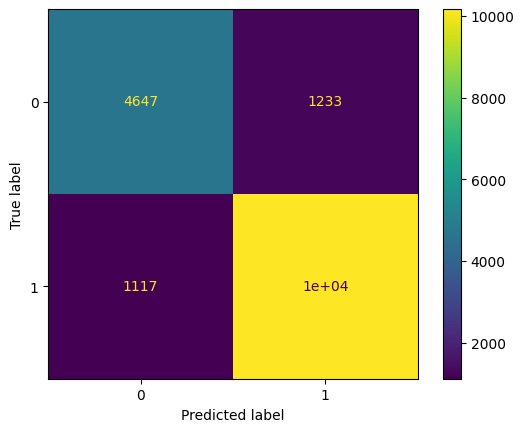

In [17]:
matriz = confusion_matrix(y_val, y_pred)

# Mostrarla visualmente
disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
disp.plot()

curva ROC

evaluar overfiting